In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')

from src.emotion.analysis.data_preprocessing import (
    DataPreprocessor,
    LinearInterpolator,
    RollingAverageSmoother,
)

from src.emotion.analysis.feature_generator import FeatureGenerator, VelocityGenerator

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('/home/moritz/Workspace/masterthesis/data/identities/team_17/2023-01-10/clip_0_6686_7987.csv')

In [3]:
feature_pipeline = [VelocityGenerator()]

feature_generator = FeatureGenerator(feature_pipeline)
feature_df = feature_generator.generate_features(df)

feature_df.head()

,Frame,ClassID,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,GazeDetections,Brightness,Velocity
0,0,person_id2,0.872598,374.885254,208.445496,0.009561,0.000811,0.000892,0.023172,0.047738,0.032971,0.884855,['person_id4'],132.380441,0.000000
1,0,person_id3,0.845503,850.473328,278.702820,0.007429,0.000340,0.021286,0.084811,0.008533,0.002538,0.875063,"['person_id4', 'person_id1']",132.380441,0.000000
2,0,person_id4,0.804104,991.508179,622.477783,0.002660,0.002170,0.059946,0.002965,0.220905,0.000952,0.710403,[],132.380441,0.000000
3,0,person_id1,0.695809,346.298340,665.733521,0.015617,0.105212,0.659331,0.110227,0.006617,0.027901,0.075095,[],132.380441,0.000000
4,5,person_id2,0.870106,374.727631,208.290314,0.015621,0.000701,0.000786,0.077209,0.131404,0.020355,0.753924,['person_id4'],132.390373,1.015733


In [4]:

# TODO: Only compute derivatives, when consecutive frames are less than 10 frame apart!
preprocessing_pipeline = [
        LinearInterpolator(),
        RollingAverageSmoother(window_size=5, cols=["Velocity"]),
    ]

preprocessor = DataPreprocessor(preprocessing_pipeline)
pre_df = preprocessor.preprocess_data(feature_df)

pre_df.head()

,Frame,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,Brightness,Velocity,ClassID
0,0,0.695809,346.298340,665.733521,0.015617,0.105212,0.659331,0.110227,0.006617,0.027901,0.075095,132.380441,6.891291,person_id1
1,1,0.692126,346.018213,665.741650,0.013334,0.099008,0.668699,0.110880,0.007938,0.024954,0.075187,132.382427,10.336937,person_id1
2,2,0.688444,345.738086,665.749780,0.011051,0.092804,0.678067,0.111534,0.009259,0.022006,0.075278,132.384414,13.782583,person_id1
3,3,0.684761,345.457959,665.757910,0.008768,0.086601,0.687435,0.112187,0.010580,0.019059,0.075370,132.386400,20.673874,person_id1
4,4,0.681078,345.177832,665.766040,0.006486,0.080397,0.696804,0.112841,0.011900,0.016111,0.075461,132.388386,25.056231,person_id1


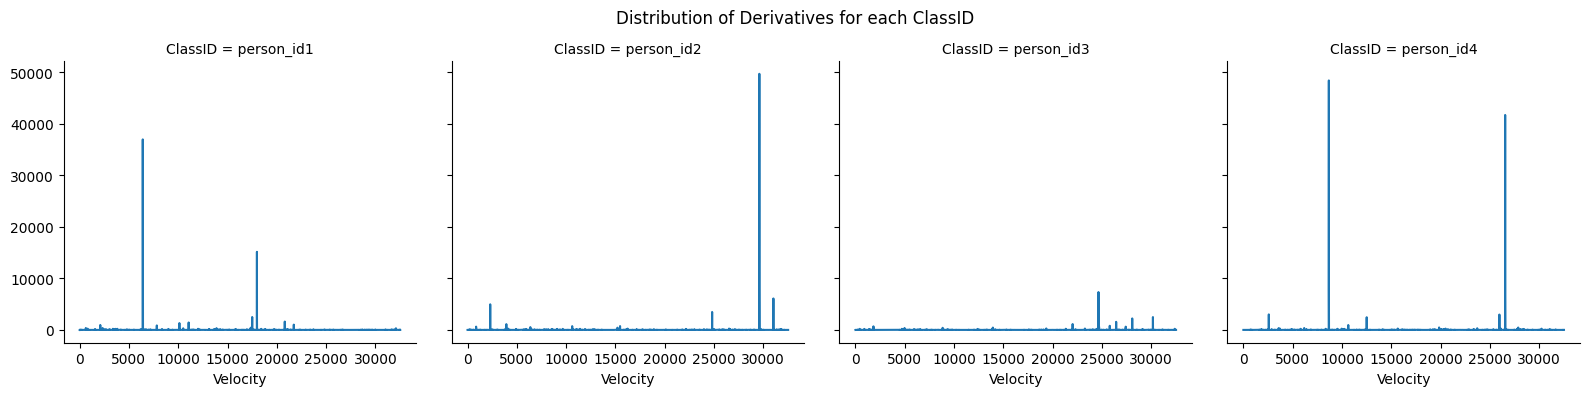

In [6]:
# Create the FacetGrid
g = sns.FacetGrid(data=pre_df, col='ClassID', col_wrap=4, height=4, sharey=True)
g.map(plt.plot, 'Velocity')

# Set the plot properties
plt.subplots_adjust(wspace=0.1, top=0.85)
g.fig.suptitle('Distribution of Derivatives for each ClassID')

# Show the plot
plt.show()

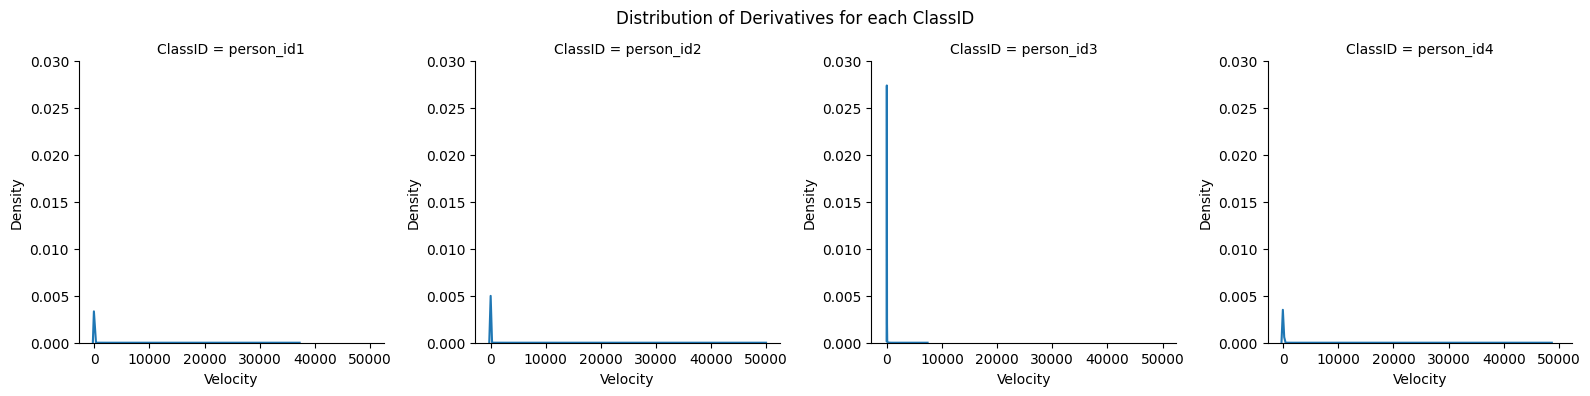

In [7]:
# TODO: Standard Normalization seems appropriate, but should we use the whole cohort as reference?
# Create the FacetGrid
g = sns.FacetGrid(data=pre_df, col='ClassID', col_wrap=4, height=4, sharey=False, sharex=True, ylim=(0, 0.03))
g.map(sns.kdeplot, 'Velocity')

plt.subplots_adjust(wspace=0.3, top=0.85)
g.fig.suptitle('Distribution of Derivatives for each ClassID')

plt.show()

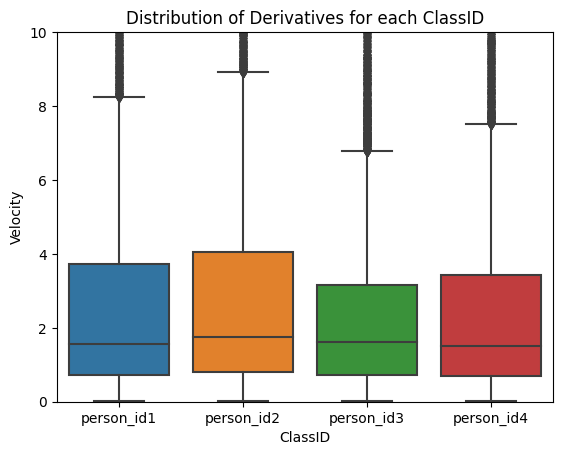

In [8]:
# Boxplot
sns.boxplot(data=pre_df, x='ClassID', y='Velocity')

plt.title('Distribution of Derivatives for each ClassID')
# Note, that we are cutting off some outliers here
plt.ylim(0, 10)

plt.show()